In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [1]:
import pprint
import random
import csv
pp = pprint.PrettyPrinter(indent=4)

In [43]:
def write_manifest(dataset, save_path, label_idx):
    samples = []
    with open(save_path, 'w') as f:
        for index, row in dataset.iterrows():
            file_path = os.path.join(row.data_dir, row.dir, row.file)
            label = label_idx.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

## Datasets

###  dataset info

In [28]:
# reddots
reddots_df = pd.read_pickle('/home/muncok/DL/dataset/SV_sets/dataframes/Reddots_Dataframe.pkl')
reddots_df['data_dir'] = '/home/muncok/DL/dataset/SV_sets/reddots_r2015q4_v1/wav/'
# commands
commands_df = pd.read_pickle('/home/muncok/DL/dataset/SV_sets/dataframes/Command_Dataframe.pkl')
commands_df['data_dir'] = '/home/muncok/DL/dataset/SV_sets/speech_commands/'
# voxceleb
voxc_df = pd.read_pickle('/home/muncok/DL/dataset/SV_sets/dataframes/Voxc_Dataframe.pkl')
voxc_df['data_dir'] = '/home/muncok/DL/dataset/SV_sets/voxceleb/'

In [29]:
reddots_df['dir'] = reddots_df.spk
commands_df['dir'] = commands_df.sent
voxc_df['dir'] = voxc_df.spk

In [30]:
entire_df = pd.concat([reddots_df, commands_df, voxc_df])

In [50]:
all_spks = entire_df.spk.unique()
all_sents = entire_df.sent.unique()
uttrs_counts = entire_df.spk.value_counts()

### Splits

In [58]:
split_dir = "../manifests/unified/"
if not os.path.isdir(split_dir):
    os.makedirs(split_dir)

In [59]:
r_idx = np.random.permutation(np.arange(len(all_spks)))
sv_spks = all_spks[r_idx[:2500]]
si_spks = all_spks[r_idx[2500:]]

In [60]:
si_df = entire_df[entire_df.spk.isin(si_spks)]
sv_df = entire_df[entire_df.spk.isin(sv_spks)]

#### si splits

In [61]:
# random sampling
si_train = si_df.sample(frac=0.8)
si_test = si_df.drop(index=si_train.index)
si_val = si_test.sample(frac=0.5)
si_test = si_test.drop(index=si_val.index) 
print("[random] train:{}, val:{}, test:{}".format(len(si_train), len(si_val), len(si_test)))

[random] train:39652, val:4956, test:4957


In [62]:
si_train['set'] = 'si_train'
si_val['set'] = 'si_val'
si_test['set'] = 'si_test'

In [63]:
si_split_df = pd.concat([si_train, si_val, si_test])
si_split_df.to_pickle(os.path.join(split_dir,"si_df.pkl"))

In [64]:
label_index = list(si_spks)
write_manifest(si_train, os.path.join(split_dir,"si_unified_train.csv"), label_index)
write_manifest(si_val, os.path.join(split_dir,"si_unified_val.csv"), label_index)
write_manifest(si_test, os.path.join(split_dir,"si_unified_test.csv"), label_index)

../manifests/unified/si_unified_train.csv was written
../manifests/unified/si_unified_val.csv was written
../manifests/unified/si_unified_test.csv was written


#### sv splits

In [65]:
sv_df.to_pickle(os.path.join(split_dir,"sv_df.pkl"))

### Audio

In [2]:
import librosa
import librosa.display
import IPython.display as ipd

In [7]:
def strip_audio(x, frame_length=1024, hop_length=256, rms_ths=0.2):
    # compute energy
    energy = numpy.array([
        sum(abs(x[i:i+frame_length]**2))
        for i in range(0, len(x), hop_length)
    ])
    rmse = librosa.feature.rmse(x, frame_length=frame_length, hop_length=hop_length)[0]
    rms_ratio = rmse/rmse.max()
    active_frames = np.nonzero(rms_ratio > rms_ths)[0]
    if len(active_frames) == 0:
        return x
    # strip continous active part
    s_sample = librosa.frames_to_samples(active_frames[0], hop_length=hop_length)[0]
    e_sample = librosa.frames_to_samples(active_frames[-1], hop_length=hop_length)[0]
    
    frames = range(len(energy))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
    librosa.display.waveplot(x, sr=sr, alpha=0.4)
    plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
    plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
    plt.legend(('Energy', 'RMSE'))

    return x[s_sample:e_sample],

In [4]:
x, sr = librosa.load("/home/muncok/DL/dataset/SV_sets/reddots_r2015q4_v1/wav/f0002/20150211152828571_f0002_275.wav",
                     sr=16000)
ipd.Audio(data=x,rate=sr) 

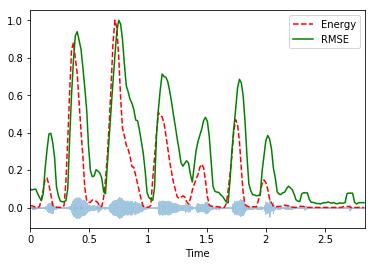

In [12]:
x, sr = librosa.load("/home/muncok/DL/dataset/SV_sets/reddots_r2015q4_v1/wav/f0002/20150211152828571_f0002_275.wav", sr=16000)
striped_x = strip_audio(x, rms_ths=0.2)
ipd.Audio(data=striped_x,rate=sr) 

In [17]:
len(striped_x[0])

30976